##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Forecasting with machine learning

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c05_forecasting_with_machine_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c05_forecasting_with_machine_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [3]:
import pandas as pd #This is used to import pandas library

data_path = "/content/drive/MyDrive/Adrima Pred/AIML_CASE.xlsx" #Path for the file
df=pd.read_excel(data_path,parse_dates=True) 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [8]:
series = np.array(df["DATA"])

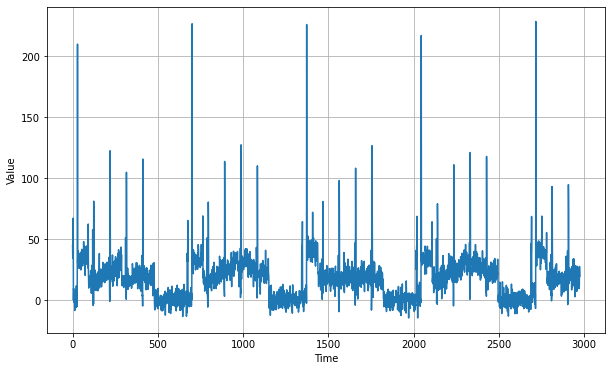

In [9]:
time = np.arange(2976)

slope = 0.05
baseline = 10
amplitude = 40
#series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

## Forecasting with Machine Learning

First, we will train a model to forecast the next step given the previous 30 steps, therefore, we need to create a dataset of 30-step windows for training.

In [10]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [11]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

### Linear Model

In [12]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
model.fit(train_set, epochs=100, validation_data=valid_set)

31/31 [==============================] - 1s 13ms/step - loss: 6.3313 - mae: 6.8097 - val_loss: 6.1949 - val_mae: 6.6751
Epoch 97/100
31/31 [==============================] - 0s 12ms/step - loss: 6.3471 - mae: 6.8278 - val_loss: 6.2100 - val_mae: 6.6884
Epoch 98/100
31/31 [==============================] - 1s 13ms/step - loss: 6.3277 - mae: 6.8032 - val_loss: 6.1850 - val_mae: 6.6647
Epoch 99/100
31/31 [==============================] - 1s 13ms/step - loss: 6.3278 - mae: 6.8060 - val_loss: 6.1901 - val_mae: 6.6703
Epoch 100/100
31/31 [==============================] - 0s 12ms/step - loss: 6.3307 - mae: 6.8088 - val_loss: 6.2023 - val_mae: 6.6811


In [13]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

31/31 [==============================] - 0s 2ms/step - loss: 8.0520 - mae: 8.5379 - lr: 0.0014
Epoch 96/100
31/31 [==============================] - 0s 2ms/step - loss: 9.6492 - mae: 10.1364 - lr: 0.0015
Epoch 97/100
31/31 [==============================] - 0s 2ms/step - loss: 13.1320 - mae: 13.6205 - lr: 0.0016
Epoch 98/100
31/31 [==============================] - 0s 2ms/step - loss: 9.5574 - mae: 10.0446 - lr: 0.0017
Epoch 99/100
31/31 [==============================] - 0s 2ms/step - loss: 12.5655 - mae: 13.0547 - lr: 0.0018
Epoch 100/100
31/31 [==============================] - 0s 2ms/step - loss: 14.3547 - mae: 14.8478 - lr: 0.0020


(1e-06, 0.001, 0.0, 20.0)

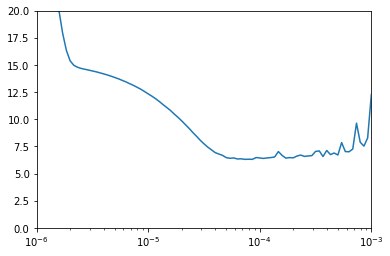

In [14]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-3, 0, 20])

In [15]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 158/500
31/31 [==============================] - 1s 24ms/step - loss: 6.2722 - mae: 6.7501 - val_loss: 6.1213 - val_mae: 6.6006
Epoch 159/500
31/31 [==============================] - 1s 13ms/step - loss: 6.2719 - mae: 6.7519 - val_loss: 6.1334 - val_mae: 6.6115
Epoch 160/500
31/31 [==============================] - 1s 24ms/step - loss: 6.2734 - mae: 6.7508 - val_loss: 6.1191 - val_mae: 6.5984
Epoch 161/500
31/31 [==============================] - 0s 13ms/step - loss: 6.2855 - mae: 6.7638 - val_loss: 6.1448 - val_mae: 6.6215


In [16]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [17]:
lin_forecast = model_forecast(model, series[split_time - window_size:-1], window_size)[:, 0]

In [18]:
lin_forecast.shape

(1976,)

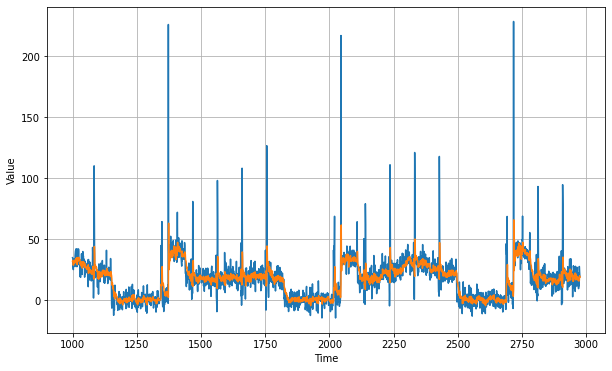

In [19]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, lin_forecast)

In [20]:
keras.metrics.mean_absolute_error(x_valid, lin_forecast).numpy()

6.584365

### Dense Model Forecasting

In [21]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
31/31 [==============================] - 1s 3ms/step - loss: 18.8042 - mae: 19.2975 - lr: 1.0000e-07
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 18.5193 - mae: 19.0115 - lr: 1.1220e-07
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 18.1764 - mae: 18.6681 - lr: 1.2589e-07
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 17.7968 - mae: 18.2879 - lr: 1.4125e-07
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 17.3706 - mae: 17.8623 - lr: 1.5849e-07
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 16.9025 - mae: 17.3940 - lr: 1.7783e-07
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 16.3795 - mae: 16.8687 - lr: 1.9953e-07
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 15.8106 - mae: 16.2991 - lr: 2.2387e-07
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 15.2059 - mae: 15.6962 

(1e-07, 0.005, 0.0, 30.0)

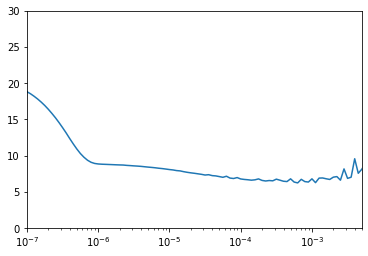

In [22]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 5e-3, 0, 30])

In [23]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

31/31 [==============================] - 1s 14ms/step - loss: 5.9763 - mae: 6.4440 - val_loss: 6.1397 - val_mae: 6.6172
Epoch 458/500
31/31 [==============================] - 1s 13ms/step - loss: 5.9805 - mae: 6.4487 - val_loss: 6.1412 - val_mae: 6.6189
Epoch 459/500
31/31 [==============================] - 1s 24ms/step - loss: 5.9700 - mae: 6.4376 - val_loss: 6.1412 - val_mae: 6.6186
Epoch 460/500
31/31 [==============================] - 1s 25ms/step - loss: 5.9684 - mae: 6.4370 - val_loss: 6.1383 - val_mae: 6.6155
Epoch 461/500
31/31 [==============================] - 1s 14ms/step - loss: 5.9681 - mae: 6.4351 - val_loss: 6.1410 - val_mae: 6.6181
Epoch 462/500
31/31 [==============================] - 1s 13ms/step - loss: 5.9763 - mae: 6.4465 - val_loss: 6.1371 - val_mae: 6.6144
Epoch 463/500
31/31 [==============================] - 1s 24ms/step - loss: 5.9701 - mae: 6.4383 - val_loss: 6.1368 - val_mae: 6.6141
Epoch 464/500
31/31 [==============================] - 1s 13ms/step - loss: 

In [24]:
dense_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

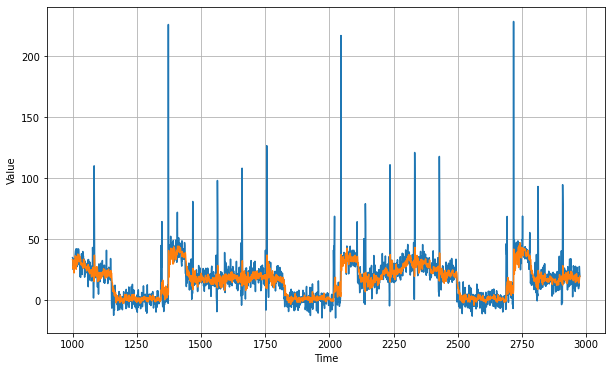

In [25]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, dense_forecast)

In [26]:
keras.metrics.mean_absolute_error(x_valid, dense_forecast).numpy()

6.5708227